# Carte de Kohonen SOMs (Self-Organizing Maps)

Détecter les anomalies causées par des intrusions représente un défi majeur dans les environnements
industriels en raison des interdépendances environnementales complexes et des protocoles
de bus de terrain propriétaires. 

Dans le papier **"Detecting Anomalies by using Self-Organizing Maps
in Industrial Environments" de Hormann and Fischer (2019)**, une méthode basée sur un réseau pour
détecter les anomalies en utilisant des réseaux neuronaux artificiels non supervisés (SOMs) est proposée.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.spatial.distance import euclidean
import os

In [2]:
# Chemins vers les répertoires
normal_dir = "C:\\Users\\beriv\\Downloads\\CICIDS2017\\Reduced\\Normal"
anomalous_dir = "C:\\Users\\beriv\\Downloads\\CICIDS2017\\Reduced\\Anomalous"

# Fonction pour charger le dataset et assigner le label
def load_dataset_with_label(filepath, label):
    df = pd.read_csv(filepath)
    df.rename(columns={df.columns[-1]: 'Label'}, inplace=True)
    df['Label'] = label 
    return df

# Chargement de chaque dataset un par un
# Chargement des datasets normaux
normal_data = pd.DataFrame()
for file in os.listdir(normal_dir):
    if file.endswith(".csv"):
        filepath = os.path.join(normal_dir, file)
        print(f"Chargement du dataset normal : {file}")
        df = load_dataset_with_label(filepath, 'Normal')
        normal_data = pd.concat([normal_data, df], ignore_index=True)

# Définition des attaques pour les datasets anomalisés
attack_labels = {
    "Reduced_Anomalous_Wednesday-workingHours.pcap_ISCX.csv": "DoS",
    "Reduced_Anomalous_Tuesday-WorkingHours.pcap_ISCX.csv": "BruteForce",
    "Reduced_Anomalous_Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv": "WebAttack",
    "Reduced_Anomalous_Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv": "Infiltration",
    "Reduced_Anomalous_Friday-WorkingHours-Morning.pcap_ISCX.csv": "Bot",
    "Reduced_Anomalous_Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv": "PortScan",
    "Reduced_Anomalous_Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv": "DDoS"
}

# Chargement des datasets anomalisés
anomalous_data = pd.DataFrame()
for file, label in attack_labels.items():
    filepath = os.path.join(anomalous_dir, file)
    if os.path.exists(filepath):
        print(f"Chargement du dataset anormal : {file} avec le label '{label}'")
        df = load_dataset_with_label(filepath, label)
        anomalous_data = pd.concat([anomalous_data, df], ignore_index=True)
    else:
        print(f"Fichier non trouvé : {file}")

# Fusion des données normales et anormales
data = pd.concat([normal_data, anomalous_data], ignore_index=True)
data.head()

Chargement du dataset normal : Reduced_Normal_Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Friday-WorkingHours-Morning.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Monday-WorkingHours.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Tuesday-WorkingHours.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Wednesday-workingHours.pcap_ISCX.csv
Chargement du dataset anormal : Reduced_Anomalous_Wednesday-workingHours.pcap_ISCX.csv avec le label 'DoS'
Chargement du dataset anormal : Reduced_Anomalous_Tuesday-WorkingHours.pcap_ISCX.csv avec le label 'BruteForce'
Chargement du dataset anormal : Reduced_Anomalou

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow Packets/s,SYN Flag Count,RST Flag Count,Label
0,40474,7182757,1,5,6.0,6.000000,0.835334,0,0,Normal
1,28907,938509,1,5,6.0,6.000000,6.393119,0,0,Normal
2,0,119995732,123,0,0.0,0.000000,1.025036,0,0,Normal
3,443,142954,10,6,55.3,658.166667,111.924115,0,0,Normal
4,17541,2548725,1,6,6.0,6.000000,2.746471,0,0,Normal


Le jeu de données est organisé en fichiers CSV
et contient des enregistrements de trafic réseau capturés via des outils comme Wireshark. Chaque
enregistrement correspond à un flux réseau.

#### Types d'attaques recensées :

- DOS (Denial of Service) et DDOS (Distributed Denial of Service)
- Brute Force : Essais multiples pour accéder à des services (ex. SSH)
- Botnet : Activité d’un botnet dans le réseau
- PortScan : Balayage des ports pour identifier des services vulnérables
- Infiltration : Tentatives d’accès non autorisé aux systèmes internes
- Exfiltration : Extraction de données sensibles hors du réseau
- Attaques Web : Injection SQL, XSS (Cross-Site Scripting), etc

## Préparation des données

In [3]:
# Encode les labels
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# On sépare les features des labels
X = data.drop('Label', axis=1)
y = data['Label']

# Normalisation des features
scaler = MinMaxScaler()
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # infinis remplacés par NaN
X.fillna(X.mean(), inplace=True)  # NaN remplacés par la moyenne de la colonne
X_scaled = scaler.fit_transform(X)

## Étape 1 : Initialisation

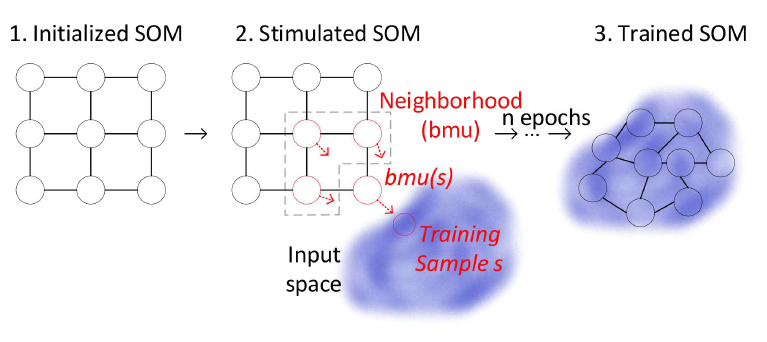

Légende : **SOM algorithm and learning phase based on (Kohonen et al., 2001)**

Source : Hormann, R. and Fischer, E. (2019), Detecting anomalies by using self-organizing maps in industrial
environments, pp. 336–344.

## Étape 2 : Entraînement du SOM (Self-Organizing Map)

Entraînement d'un seul MiniSOM (pour des questions computationnelles) sur 100 itérations et un learning rate de 0.5

l'un pour regrouper les données du réseau et l'autre pour trouver les centroïdes des clusters.

In [9]:
import gc
gc.collect()

490

In [4]:
som_shape = (10, 10)
som = MiniSom(som_shape[0], som_shape[1], X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_scaled) # poids des neurones
som.train_random(X_scaled, 100)  # On l'entraîne pour 100 itérations

Chaque neurone de la grille (10x10) agit comme un cluster représentatif.

En entraînant le réseau, MiniSom apprend à regrouper les points de données dans des zones spécifiques de la grille, créant des regroupements naturels.

## Étape 3 : Identification des clusters

In [5]:
bmu_mapping = np.array([som.winner(x) for x in X_scaled]) # Pour chaque vecteur d'entrée x dans X_scaled, la méthode winner 
# retourne les coordonnées du neurone gagnant (BMU : Best Matching Unit) dans la grille SOM
clusters = {}
for idx, bmu in enumerate(bmu_mapping):
    bmu_tuple = tuple(bmu)
    if bmu_tuple not in clusters:
        clusters[bmu_tuple] = []
    clusters[bmu_tuple].append(X_scaled[idx])

# Calcul des centroïdes
centroids = {}
for bmu, points in clusters.items():
    centroids[bmu] = np.mean(points, axis=0)

## Étape 4 : Phase opérationnelle (détection d'anomalies avec deux intervalles de confiance)

1er intervalle de confiance : pour déterminer si un échantillon est trop éloigné de son unité correspondante la plus proche.

2nd intervalle de confiance : afin de minimiser les faux positifs, qui constituent un inconvénient majeur des méthodes d'apprentissage automatique dans la détection des anomalies

In [6]:
def detect_anomalies(new_samples, confidence_bmu=0.95, confidence_centroid=0.95):
    """
    Détecte les anomalies en fonction des distances au BMU et au centroïde.
    """
    anomalies = []
    
    # Calcul des seuils pour le premier intervalle de confiance (BMU)
    bmu_distances = [euclidean(x, som.get_weights()[som.winner(x)]) for x in X_scaled]
    bmu_threshold = np.percentile(bmu_distances, confidence_bmu * 100)
    
    # Calcul des seuils pour le deuxième intervalle de confiance (centroïdes)
    centroid_distances = []
    for bmu, points in clusters.items():
        for point in points:
            centroid_distances.append(euclidean(point, centroids[bmu]))
    centroid_threshold = np.percentile(centroid_distances, confidence_centroid * 100)
    
    # Vérification des anomalies pour chaque nouveau point
    for sample in new_samples:
        # Distance au BMU
        bmu = som.winner(sample)
        distance_bmu = euclidean(sample, som.get_weights()[bmu])
        
        # Distance au centroïde du cluster
        distance_centroid = euclidean(sample, centroids.get(bmu, np.zeros_like(sample)))
        
        # Anomalie si les distances dépassent les seuils
        if distance_bmu > bmu_threshold or distance_centroid > centroid_threshold:
            anomalies.append((sample, bmu, distance_bmu, distance_centroid))
    
    return anomalies

Test de détection des anomalies en sélectionnant un échantillon de données du dataset :

In [8]:
test_samples = X_scaled[:10]  # 10 premières lignes normalisées du dataset
anomalies = detect_anomalies(test_samples)

# Affichage des anomalies détectées
print("Anomalies détectées :", anomalies)

Anomalies détectées : [(array([9.49641386e-01, 8.34330611e-01, 2.58800511e-05, 3.50549194e-05,
       3.64297454e-01, 1.60163270e-03, 4.00000030e-01, 1.00000000e+00,
       0.00000000e+00]), (7, 6), 0.8368830379316394, 0.9678927588476078)]


In [ ]:
# Association de chaque BMU à la classe dominante
bmu_to_class = {}
for bmu in unique_bmus:
    indices = [i for i, x in enumerate(bmu_mapping) if tuple(x) == tuple(bmu)]
    class_counts = Counter(y[indices])
    most_common_class = class_counts.most_common(1)[0][0]
    bmu_to_class[tuple(bmu)] = most_common_class

# Association de chaque point à la classe dominante de son BMU
y_pred_mapped = np.array([bmu_to_class[tuple(bmu)] for bmu in bmu_mapping])

Définition des seuils des intervalles de confiance : 

confidence_bmu = 0.95

confidence_centroid = 0.99

Seuil de distance BMU (intervalle de confiance 95.0%): 0.2111
Seuil de distance centroïde (intervalle de confiance 99.0%): 0.2993


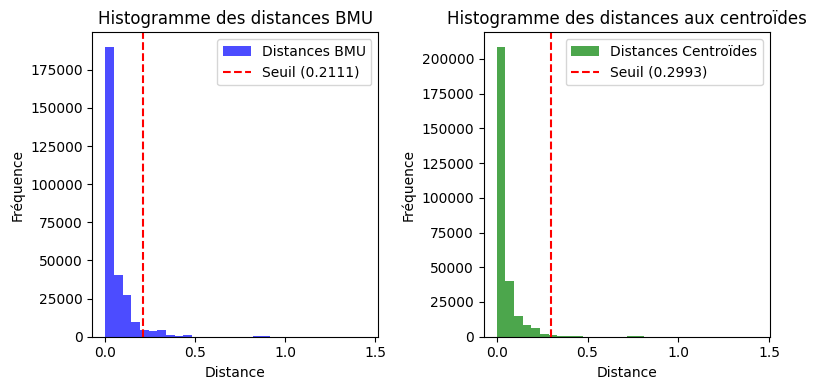

Anomalie détectée : Sample [ 7.63009309e-06  1.00000018e-08 -4.65840921e-06  1.55799642e-06
  1.01022249e-04  1.80183679e-04  4.00000060e-01  8.00000000e-01
  1.00000000e-01], BMU (7, 4), Distance BMU 0.1582, Distance Centroid 0.3060


c:\Users\beriv\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



: 

In [36]:
# Calcul des distances BMU
bmu_distances = [np.linalg.norm(x - som.get_weights()[som.winner(x)]) for x in X_scaled]

# Calcul des distances aux centroïdes
centroid_distances = []
for bmu, points in clusters.items():
    centroid = centroids[bmu]
    centroid_distances.extend([np.linalg.norm(point - centroid) for point in points])

# Définir les seuils des intervalles de confiance
confidence_bmu = 0.95
confidence_centroid = 0.99
bmu_threshold = np.percentile(bmu_distances, confidence_bmu * 100)
centroid_threshold = np.percentile(centroid_distances, confidence_centroid * 100)

# Affichage des seuils pour vérification
print(f"Seuil de distance BMU (intervalle de confiance {confidence_bmu * 100}%): {bmu_threshold:.4f}")
print(f"Seuil de distance centroïde (intervalle de confiance {confidence_centroid * 100}%): {centroid_threshold:.4f}")

# Visualisation des intervalles de confiance
plt.figure(figsize=(8, 4))

# Histogramme des distances BMU
plt.subplot(1, 2, 1)
plt.hist(bmu_distances, bins=30, color='blue', alpha=0.7, label='Distances BMU')
plt.axvline(bmu_threshold, color='red', linestyle='--', label=f"Seuil ({bmu_threshold:.4f})")
plt.title("Histogramme des distances BMU")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.legend()

# Histogramme des distances centroïdes
plt.subplot(1, 2, 2)
plt.hist(centroid_distances, bins=30, color='green', alpha=0.7, label='Distances Centroïdes')
plt.axvline(centroid_threshold, color='red', linestyle='--', label=f"Seuil ({centroid_threshold:.4f})")
plt.title("Histogramme des distances aux centroïdes")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.legend()

plt.tight_layout()
plt.show()

# Analyse des anomalies
def detect_anomalies(new_samples, confidence_bmu=0.95, confidence_centroid=0.99):
    anomalies = []
    for sample in new_samples:
        bmu = som.winner(sample)
        distance_bmu = np.linalg.norm(sample - som.get_weights()[bmu])
        centroid = centroids[bmu]
        distance_centroid = np.linalg.norm(sample - centroid)

        # Vérification des seuils
        if distance_bmu > bmu_threshold or distance_centroid > centroid_threshold:
            anomalies.append((sample, bmu, distance_bmu, distance_centroid))
    return anomalies

# Exemple d'échantillons de test
new_samples = scaler.transform([[0.5, 0.2, 0.1, 0.4, 0.6, 0.7, 0.3, 0.8, 0.1]])  # Exemple
detected_anomalies = detect_anomalies(new_samples)

# Afficher les anomalies détectées
for anomaly in detected_anomalies:
    print(f"Anomalie détectée : Sample {anomaly[0]}, BMU {anomaly[1]}, Distance BMU {anomaly[2]:.4f}, Distance Centroid {anomaly[3]:.4f}")

Lors de la détection des anomalies, un exemple d’échantillon a été identifié comme anomalie.

Bien que sa distance BMU soit inférieure au seuil (0.1582 < 0.2111), sa distance au centroïde dépasse le seuil (0.3060 > 0.2993). Cela suggère que l’échantillon est proche de son BMU, mais relativement éloigné du centroïde de son cluster, indiquant une anomalie structurelle ou locale.

## Étape 5 : Évaluation du modèle

In [15]:
print("Classification Report:")
print(classification_report(y, y_pred_mapped, target_names=label_encoder.classes_, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

         Bot       0.00      0.00      0.00       197
  BruteForce       0.00      0.00      0.00      1384
        DDoS       0.62      0.47      0.54     12803
         DoS       0.82      0.53      0.65     25267
Infiltration       0.00      0.00      0.00         4
      Normal       0.91      0.96      0.94    227311
    PortScan       0.65      0.71      0.68     15893
   WebAttack       0.00      0.00      0.00       218

    accuracy                           0.88    283077
   macro avg       0.38      0.34      0.35    283077
weighted avg       0.87      0.88      0.87    283077



Les attaques prédominantes dans l'ensemble de test sont celles qui sont les mieux prédites : Dos, DDos, PortScan

Les instances normales sont très bien prédites : 0.91 de précision

#### Codebooks

Les codebooks d’un SOM (Self-Organizing Map) représentent les poids associés à chaque neurone pour chaque feature. Ils servent de points de référence pour regrouper des données similaires dans l’espace des features. Chaque neurone de la carte est responsable de "représenter" un groupe de données similaires, et les valeurs des codebooks montrent les caractéristiques typiques des données associées à un neurone particulier. 

Ces visualisations permettent de mieux comprendre comment le SOM a organisé les données et quels neurones sont influencés par des features spécifiques.

In [33]:
# Définition des paramètres pour les sous-graphiques
num_features = X_scaled.shape[1]
cols = 5  # Nombre de colonnes pour les subplots
rows = int(np.ceil(num_features / cols))  # Nombre de lignes basé sur les features

# Initialisation des sous-graphiques
fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=[f"{feature}" for i, feature in enumerate(X.columns)],
    horizontal_spacing=0.1,  # Espacement horizontal entre les subplots
    vertical_spacing=0.2,    # Espacement vertical entre les subplots
)

# Ajouter chaque codebook (feature) à un subplot
for i in range(num_features):
    row = i // cols + 1
    col = i % cols + 1
    fig.add_trace(
        go.Heatmap(
            z=som.get_weights()[:, :, i],
            colorscale="plasma",
            colorbar=dict(
                title=f"Feature {i+1}",
                titleside="right",
                titlefont=dict(size=10),
                tickfont=dict(size=8),
                len=0.4,
                thickness=10,
                xpad=20,
                ypad=10,
            ),
            showscale=(col == cols),
        ),
        row=row,
        col=col,
    )
    
fig.update_layout(
    title="Codebooks pour chaque Feature (SOM)",
    height=250 * rows,
    width=1200,
    showlegend=False,
    template="plotly_white",
)
fig.show()


Les codebooks montrent des zones où les valeurs sont fortement activées (en jaune). 

--> Pourrait indiquer que certains ports ou durées de flux spécifiques sont particulièrement représentatifs des données associées à ces neurones. 

--> Peut refléter des comportements spécifiques, comme des attaques ciblant des ports particuliers ou des durées anormalement longues dans les flux.

Contrairement aux autres matrices, la caractéristique RST Flag Count semble uniformément distribuée, ce qui indique qu’elle a peu d’impact discriminant dans l’organisation des clusters, qu’elle est moins représentée dans les données. On le confirme via une description statistique incluant moyenne, variance et écart-type de la caractéristique :

In [24]:
print(data["RST Flag Count"].describe())

count    283077.000000
mean          0.000187
std           0.013682
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: RST Flag Count, dtype: float64


#### U-Matrix

La U-Matrix (Unified Distance Matrix) est une représentation visuelle qui met en évidence les distances entre les neurones adjacents d’une carte auto-organisée (SOM). Elle permet de comprendre la structure des clusters formés par les données.

In [28]:
# Calcul de la U-Matrix
u_matrix = som.distance_map()  # Distance entre les poids des neurones adjacents
fig = go.Figure()

# U-Matrix en tant que Heatmap
fig.add_trace(
    go.Heatmap(
        z=u_matrix,
        colorscale="plasma",  
        colorbar=dict(title="Distance"),
        showscale=True,
    )
)

# Superposition des valeurs des classes dominantes
for x in range(u_matrix.shape[0]):  # Parcourt les neurones SOM
    for y in range(u_matrix.shape[1]):
        # Obtient la classe dominante pour chaque neurone si elle existe
        value = bmu_to_class.get((x, y), None)
        if value is not None:  # Si une classe est associée au neurone
            fig.add_trace(
                go.Scatter(
                    x=[y + 0.5],
                    y=[x + 0.5],
                    text=[label_encoder.inverse_transform([value])[0]], 
                    mode="text",
                    textfont=dict(
                        color="white",
                        size=8,
                        family="Arial",
                    ),
                    showlegend=False,
                )
            )

fig.update_layout(
    title="U-Matrix avec superposition des classes dominantes",
    xaxis=dict(title="Neurone X", showgrid=False),
    yaxis=dict(title="Neurone Y", showgrid=False),
    height=600,
    width=600,
    template="plotly_white",  # Fond blanc
)
fig.show()

Les couleurs de la matrice représentent ces distances :

- Les zones bleu foncé indiquent des distances faibles entre les neurones, ce qui signifie que les poids
des neurones voisins sont similaires et appartiennent probablement au même cluster. 
- À l’inverse, les zones jaunes ou oranges vives représentent des distances élevées, correspondant à des transitions
entre différents clusters.

On observe une prépondérance de la classe "Normal" sur une majorité des neurones, ce qui est attendu étant donné l’importance de cette classe dans le dataset. Cependant, des neurones comme ceux associés à "PortScan", "DDoS" ou "DoS" apparaissent comme des zones spécifiques où ces types d’attaques dominent. Ces zones peuvent indiquer que le SOM a réussi à séparer ces types d’anomalies des données normales.

#### Conclusion sur les cartes de Kohonen

Les résultats montrent une précision notable pour la détection de comportements normaux (f1-
score de 0.94) et une performance variable pour les anomalies, les attaques comme "DDoS" et
"PortScan" étant mieux détectées grâce à leurs signatures distinctes. Cependant, certaines classes,
comme "WebAttack" ou "Infiltration", ont été peu ou mal représentées, en raison d’un faible nombre
d’échantillons ou de leurs similarités avec d’autres comportements.

En conclusion, cette approche a démontré son utilité dans la classification et la détection des anomalies
dans des données réseau complexes. Bien que les résultats puissent encore être optimisés pour
certaines classes rares, la méthode est robuste et offre une vision claire des structures sous-jacentes
des données, permettant de mieux comprendre les relations entre les différentes caractéristiques.